In [1]:
import csv
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train = pd.read_csv("train.csv")

**Checking for Null Values**

In [3]:
train.isnull()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
512082,False,False,False,False,False,False,False,False,False,False,False
512083,False,False,False,False,False,False,False,False,False,False,False
512084,False,False,False,False,False,False,False,False,False,False,False
512085,False,False,False,False,False,False,False,False,False,False,False


In [4]:
sum([True for idx,row in train.iterrows() if any(row.isnull())])

1764

**Thus there are 1764 rows which contain atleast a single cell with Null value, also rows containing infinty values**  
We will drop such rows

In [5]:
train.replace([np.inf, -np.inf], np.nan)
train = train.dropna()
train.shape

(510323, 11)

In [6]:
cols = train.columns
for col in cols[1: len(cols) - 1]:
  #print (col)
  if len(train[col].unique()) < 10:
    print (col, train[col].unique())

Course_Domain ['Development' 'Software Marketing' 'Finance & Accounting' 'Business']
Course_Type ['Course' 'Program' 'Degree']
Short_Promotion [0 1]
Public_Holiday [1 0]
Long_Promotion [1 0]


**Converting categorical data to numerical form using simple codes like 1, 2, 3, .... number of unique values**

In [7]:
train["Course_Domain"].replace({'Development':"1", 'Software Marketing':"2", 'Finance & Accounting':"3", 'Business':"4"}, inplace=True)
train["Course_Type"].replace({'Course':"1", 'Program':"2", 'Degree':"3"}, inplace=True)

train.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,1,1,0,1,1,11004,0.007,81
1,2,2,1,1,1,0,0,1,13650,0.007,79
2,3,3,1,1,1,0,0,1,11655,0.007,75
3,4,4,1,1,1,0,0,1,12054,0.007,80
4,5,5,1,1,1,0,0,1,6804,0.007,41


In [0]:
train["Course_Domain"] = train["Course_Domain"].astype(str).astype(int)
train["Course_Type"] = train["Course_Type"].astype(str).astype(int)

**Plotting distributions for a few columns to check for abnormalities**

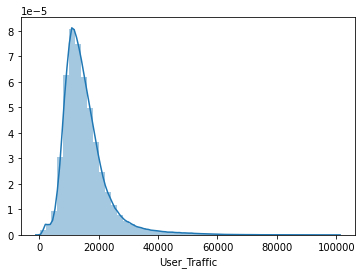

In [9]:
sns.distplot(train["User_Traffic"])

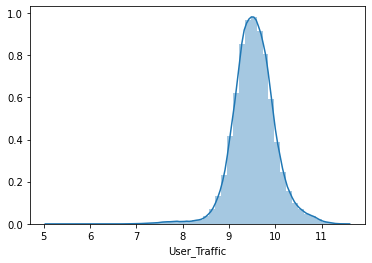

In [10]:
sns.distplot(np.log(train["User_Traffic"]))

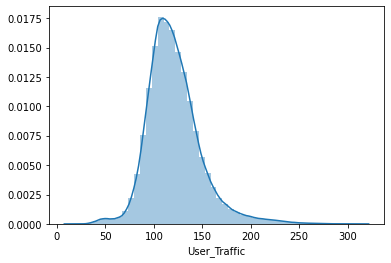

In [11]:
sns.distplot(train["User_Traffic"]**0.5)

**Thus, User Traffic was skewed without any transformation. So I took log and square root transformations, out of which square root transformation seems best yet.**  
Hence, I am modifying the User Traffic Column by taking it's square root.

In [0]:
train["User_Traffic"] = train["User_Traffic"] ** 0.5

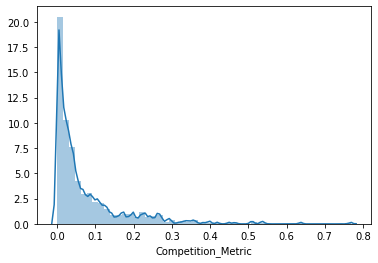

In [13]:
sns.distplot(train["Competition_Metric"])

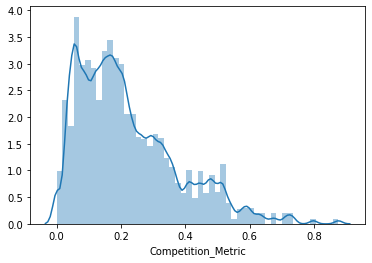

In [15]:
sns.distplot(train["Competition_Metric"]**0.5)

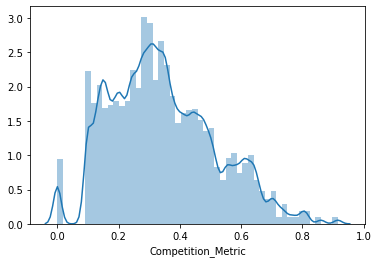

In [16]:
sns.distplot(train["Competition_Metric"] ** (1/3))

**Data for Competition Metric was skewed too, thus appropriate transformations were needed. Log transformation could not be done because of presence of 0 values in the column. Instead a cube root transformation has been taken**  
While the results are not as good as for User Traffic, cube root transformation provides relatively better results than other transformations that have been tried.

In [0]:
train["Competition_Metric"] = train["Competition_Metric"] ** (1/3)

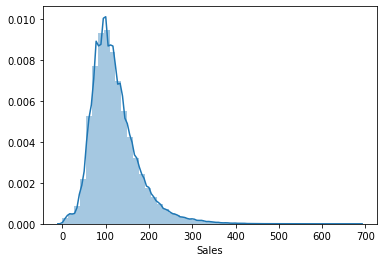

In [19]:
sns.distplot(train["Sales"])

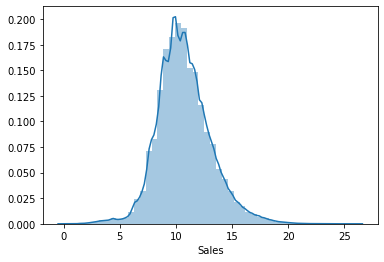

In [21]:
sns.distplot(train["Sales"] ** 0.5)

**Values in the Sales column were skewed too, hence a transformation was necessary. Again, the log transformation couldn't be taken because of 0 values in the column**  
Only a single square root transformation was taken because it gave satisfactory results.

In [0]:
train["Sales"] = train["Sales"] ** 0.5

**Splitting the date into training and cross validation sets**

In [0]:
#Shuffling the dataset first
train = train.sample(frac=1).reset_index(drop=True)

#Doing a 70-30 split (approx)
train_split = train.loc[:350000]
validation_split = train.loc[350000:]

#train_split.shape
#validation_split.shape

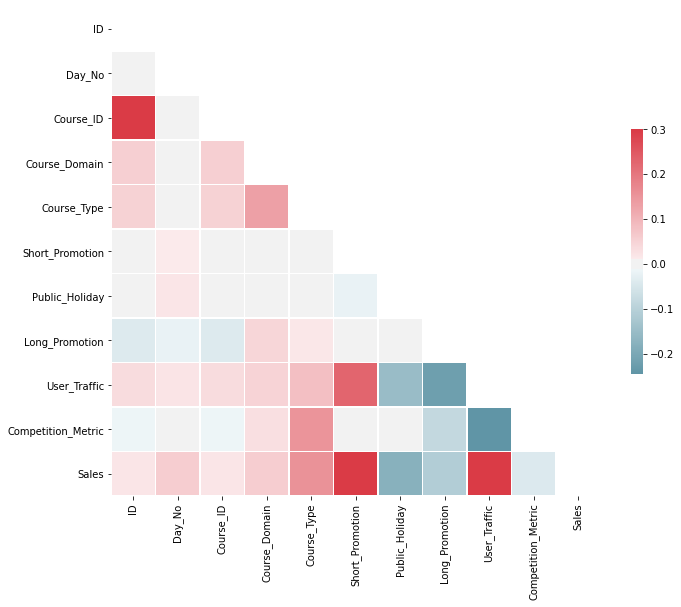

In [24]:
corr = train_split.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
print (corr)

                          ID    Day_No  ...  Competition_Metric     Sales
ID                  1.000000  0.001067  ...           -0.007431  0.017968
Day_No              0.001067  1.000000  ...            0.003229  0.060120
Course_ID           0.999996 -0.000489  ...           -0.007385  0.017817
Course_Domain       0.056440  0.000242  ...           -0.044007  0.049499
Course_Type         0.051390  0.005799  ...            0.129764  0.148579
Short_Promotion    -0.000004  0.014644  ...            0.000182  0.367558
Public_Holiday      0.001308  0.019101  ...           -0.000491 -0.135046
Long_Promotion     -0.040347 -0.020185  ...           -0.119382 -0.110650
User_Traffic        0.034415  0.021620  ...           -0.148775  0.829425
Competition_Metric -0.007431  0.003229  ...            1.000000 -0.022085
Sales               0.017968  0.060120  ...           -0.022085  1.000000

[11 rows x 11 columns]


**From the graphic we see that "Short Promotion" and "User Traffic" are highly correlated, followed by "Course Type" (positively) with sales and thus could be useful in prediction of sales. "Course ID" has an unusually high correlation with Sales (0.999..) and needs further investigation.**  
Also, there is some amount of correlation between Short Promotion and User Traffic which may expain why both these columns have a high correlation with sales, and thus we can maybe consider one of these columns as redundant, and use only one of them